# King County EDA

![King County Skyline](kcpic.jpeg)

## Goal of the Analysis

According to the wishes of the stakeholder, the focus of the analysis is on splitting the data in way, which makes it possible to compare houses in the city with houses on the countryside. Furthermore, a distinction between big and small houses was requested. Accordingly, the main goal is to find differences/similarities between these categories.

### Agenda
* **First look at the data**
* **Formulating assumptions and areas to investigate**
* **Cleaning and preparing the data**
* **Analysis & revisiting the assumptions**
* **Results**
* **Recommendations**

# First overview of the data

In [2]:
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import folium
from folium.plugins import HeatMap
import sklearn
from sklearn.model_selection import train_test_split

In [11]:
def display_missing(df):    
    for col in df.columns.tolist():   
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))   
    print('\n')
    
def plot_box_numeric(df, ncols=7, nrows=2, figsize=(20, 10)):
    df_num = df.select_dtypes(include = ['float', 'int'])
    
    #if len(df_num.columns) > ncols*nrows:
        #raise "Change ncols and nrows. Too many variables for this size"
    
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    index = 0
    axs = axs.flatten()
    for k,v in df_num.items():
        sns.boxplot(y=k, data=df_num, ax=axs[index])
        index += 1
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [6]:
# read the original file
df = pd.read_csv("King_County_house_prices_dataset.csv")

# handling bathrooms
df["bathrooms"] = df["bathrooms"].apply(lambda x: round(x))

# convert variables
# following variables are in thousand dollars and sqft
df["price"] = df["price"].apply(lambda x: x*0.001)
df["sqft_lot"] = df["sqft_lot"].apply(lambda x: x*0.001)
df["sqft_living"] = df["sqft_living"].apply(lambda x: x*0.001)
df["sqft_above"] = df["sqft_above"].apply(lambda x: x*0.001)
df["sqft_living15"] = df["sqft_living15"].apply(lambda x: x*0.001)
df["sqft_lot15"] = df["sqft_lot15"].apply(lambda x: x*0.001)

df.sqft_basement = pd.to_numeric(df.sqft_basement, errors='coerce')
df["sqft_basement"] = df["sqft_basement"].apply(lambda x: x*0.001)

# df for LinReg
df2 = df.copy()

df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221.9,3,1,1.18,5.650,1.0,NaN,0.0,...,7,1.18,0.00,1955,0.0,98178,47.5112,-122.257,1.34,5.650
1,6414100192,12/9/2014,538.0,3,2,2.57,7.242,2.0,0.0,0.0,...,7,2.17,0.40,1951,1991.0,98125,47.7210,-122.319,1.69,7.639
2,5631500400,2/25/2015,180.0,2,1,0.77,10.000,1.0,0.0,0.0,...,6,0.77,0.00,1933,NaN,98028,47.7379,-122.233,2.72,8.062
3,2487200875,12/9/2014,604.0,4,3,1.96,5.000,1.0,0.0,0.0,...,7,1.05,0.91,1965,0.0,98136,47.5208,-122.393,1.36,5.000
4,1954400510,2/18/2015,510.0,3,2,1.68,8.080,1.0,0.0,0.0,...,8,1.68,0.00,1987,0.0,98074,47.6168,-122.045,1.80,7.503


# Assumptions

Based on the first look at the data set and the requirement of the customer, we make the following assumptions:
1. **Houses in the city will be more expensive in comparison to houses in the countryside** As the customer wants to buy two houses, one in the city and one on the countryside, this information will influence the decision
2. **The size of the house influences the price (both in the city and in the countryside)** 
3. **Applying the wishes of stakeholder (aprox. 2 bedrooms, good condition, splitting city/countryside, no renovation in the countryside house) will be possible.** A first sight on the data didn't indicate the opposite
4. **Big house in the city + big house in the countryside will be most expensive combination for the customer** In view of the fact, that the customer wants to buy two houses in two whole different areas, this might not be the best option

## Cleaning and preparing the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  int64  
 5   sqft_living    21597 non-null  float64
 6   sqft_lot       21597 non-null  float64
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  float64
 13  sqft_basement  21143 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Missing values

Take a look at missing values and how to replace them

In [5]:
print("count of missing values:")
print("view:\t\t ", df.query("view == 'nan'").id.count())
print("waterfront:\t ", df.query("waterfront == 'nan'").id.count())
print("yr_renovated:\t ",df.query("yr_renovated == 'nan'").id.count())

count of missing values:
view:		  63
waterfront:	  2376
yr_renovated:	  3842


**Missing values**: ```waterfront, view, yr_renovated``` have missing values. I make the assumption that if there are no values in these columns, that there is no ```waterfront```, the house has not been ```viewed``` and not ```renovated```. Therefore all missing values will be repaced with a value of ```0```

 

In [10]:
# Replacing missing values
df.waterfront = df.waterfront.fillna(0).astype("int8")
df.view = df.view.fillna(0).astype("int8")
df.yr_renovated = df.yr_renovated.fillna(0).astype("int16")

##       Outliers

In order to identify outliers, all numeric variables are box plotted

In [14]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21143.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.00000,21597.000000
mean,4.580474e+09,540.296574,3.373200,2.059777,2.080322,15.099409,1.494096,0.006760,0.233181,3.409825,7.657915,1.788597,0.291852,1970.999676,68.758207,98077.951845,47.560093,-122.213982,1.98662,12.758284
std,2.876736e+09,367.368140,0.926299,0.754435,0.918106,41.412637,0.539683,0.081944,0.764673,0.650546,1.173200,0.827760,0.442498,29.375234,364.037499,53.513072,0.138552,0.140724,0.68523,27.274442
min,1.000102e+06,78.000000,1.000000,0.000000,0.370000,0.520000,1.000000,0.000000,0.000000,1.000000,3.000000,0.370000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,0.39900,0.651000
25%,2.123049e+09,322.000000,3.000000,2.000000,1.430000,5.040000,1.000000,0.000000,0.000000,3.000000,7.000000,1.190000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1.49000,5.100000
50%,3.904930e+09,450.000000,3.000000,2.000000,1.910000,7.618000,1.500000,0.000000,0.000000,3.000000,7.000000,1.560000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1.84000,7.620000
75%,7.308900e+09,645.000000,4.000000,2.000000,2.550000,10.685000,2.000000,0.000000,0.000000,4.000000,8.000000,2.210000,0.560000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2.36000,10.083000
max,9.900000e+09,7700.000000,33.000000,8.000000,13.540000,1651.359000,3.500000,1.000000,4.000000,5.000000,13.000000,9.410000,4.820000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6.21000,871.200000


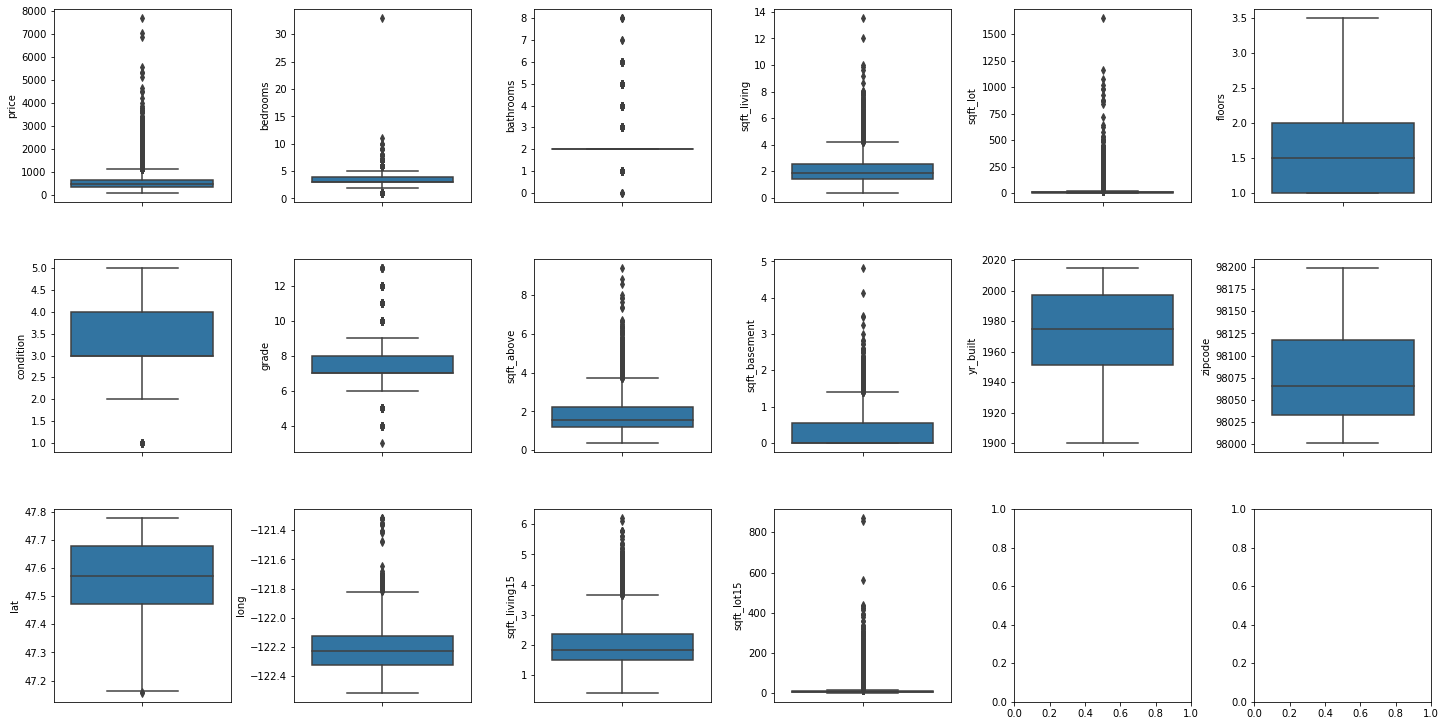

In [12]:
plot_box_numeric(df.drop(["id"], axis=1), ncols=6, nrows=3, figsize=(20, 10))

According to the boxplots, following adjustments are made:

In [26]:
df = df.query("bedrooms < 30")
df = df.query("price < 2000")
df = df.query("sqft_living < 12")
df = df.query("sqft_lot < 1000")
df = df.query("condition > 1")
df = df.query("sqft_lot15 < 400")

```bedrooms, price, sqft_living, sqft_lot, condition and sqft_lot15``` were changed, beacause the boxplots indicated for unreasonably high or low values in these features

##      Distribution of price

The price is in the end one of the most important variables in this dataset. This is worth a second look.

Text(0.5, 1.0, 'Distributuion of house prices')

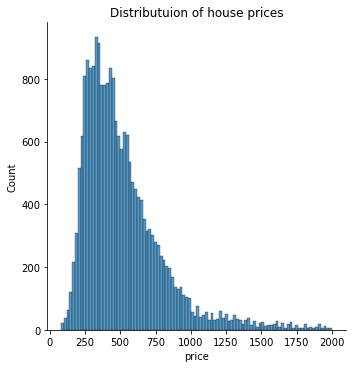

In [25]:
sns.displot(df, x=df["price"], bins=100, binwidth=20);
plt.title("Distributuion of house prices")

We can see that, despite removing some outliers, the ```price distributuion``` is still right-skewed, meaning that we still have many outliers on the higher price segment

#      Correlations

Let's check the dataset for interesting correlations. ```id, waterfront, zipcode and yr_renovated```have  been excluded.

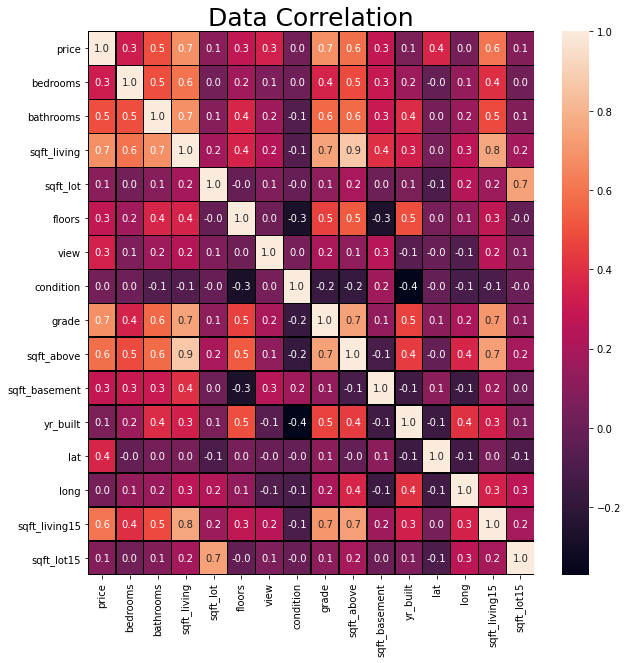

In [34]:
plt.subplots(figsize=(10,10))
sns.heatmap(df.drop(["id", "waterfront", "zipcode", "yr_renovated"], axis=1).corr(),annot=True,linewidths=0.5,linecolor="Black",fmt="1.1f")
plt.title("Data Correlation",fontsize=25)
plt.show()

**```price```**: There seem to be correltaions with ```bathrooms, sqft_living, grade, sqft_above and sqft_living```

Otherwise ```bathrooms```and ```bedrooms```are correlated with the grade and the sqft-columns.

The ```sqft-columns``` are correlated with each other.

Let's take a closer look to the relationship of ```price``` and ```sqft_living``` and ```price``` and ```grade```

Text(0.5, 0, 'grade')

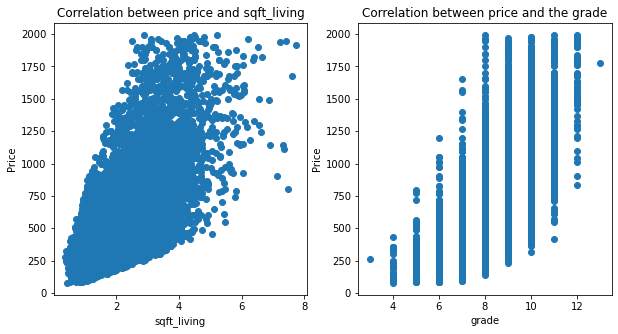

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(df.sqft_living, df.price)
plt.title('Correlation between price and sqft_living')
plt.ylabel('Price')
plt.xlabel('sqft_living')

plt.subplot(1, 2, 2)
plt.scatter(df.grade, df.price)
plt.title('Correlation between price and the grade')
plt.ylabel('Price')
plt.xlabel('grade')

The bigger the houses, the higher the ```price``` tends to be. The same thing with the ```grade```.

#   Split the data in a city and nature dataframe

In [17]:
from bokeh.plotting import figure, output_notebook, show, output_file
from bokeh.tile_providers import get_provider, Vendors
import numpy as np

# file to save the model  
#output_file("kcmap.html")  
output_notebook()
# instantiating the figure object  
graph = figure(title = "Map of House Sales in King County", x_axis_type="mercator", y_axis_type="mercator")
#tile provider
#tile_provider = get_provider(OSM)
#graph.add_tile(tile_provider)
# name of the x-axis  
graph.xaxis.axis_label = "Long"
# name of the y-axis  
graph.yaxis.axis_label = "Lat"
# points to be plotted converted to mercator
k = 6378137
x = df.long.apply(lambda x: x * (k * np.pi/180.0))
y = df.lat.apply(lambda x: np.log(np.tan((90 + x) * np.pi/360.0)) * k)
size = 2
# plotting the graph  
graph.scatter(x, y, 
              fill_alpha=0.1,
              size = size)  
# displaying the model  
show(graph)

Loading BokehJS ...

This is a little helper for getting the ```longitude``` to spllit the data. -122.1 was chosen

In [50]:
df_nature = df.query("long >= -122.1")
print(df_nature.shape)

df_city = df.query("long < -122.1")
print(df_city.shape)

(4441, 21)
(16908, 21)


Please notice, that the ```nature_df```is smaller than the ```city_df```


# Analysis of city and countryside houses

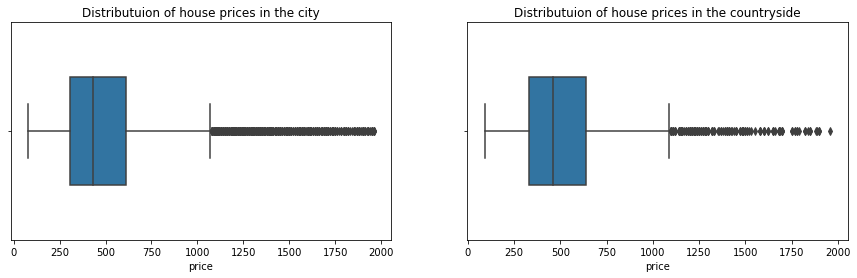

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,4))

sns.boxplot( x=df_city["price"], width=0.5, ax=axes[0]).set_title('Distributuion of house prices in the city');
sns.boxplot( x=df_nature["price"], width=0.5, ax=axes[1]).set_title('Distributuion of house prices in the countryside');

You cann see that the average ```house price``` in the **city is slightly lower** than in the countryside! This is against my assumption in the beginning.

### Inspecting the realtionship of house prices and variables

In this analysis we are including ```bedrooms``` and  ```condition``` based on the interest of the stakeholder

        Count of bedrooms in the countryside 			 Count of bedrooms in the city


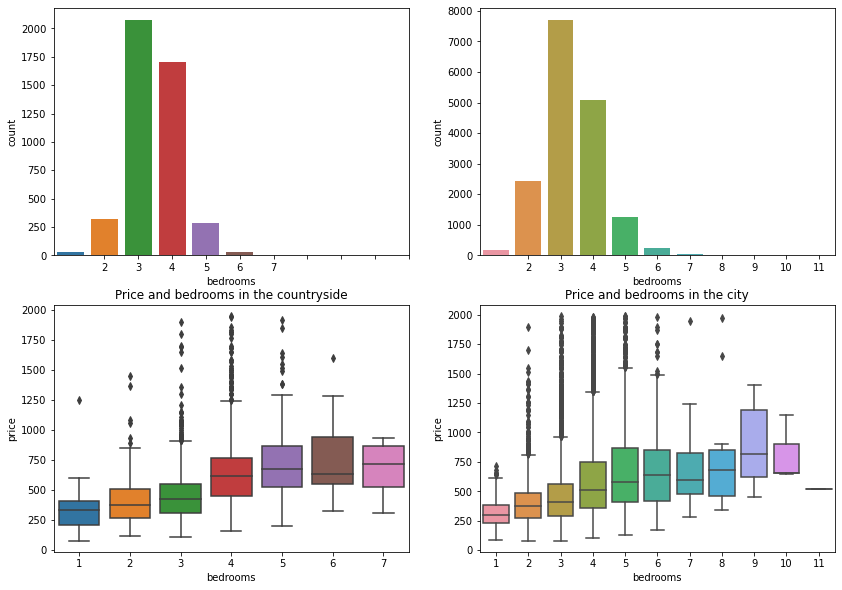

In [67]:
warnings.filterwarnings('ignore')

bedrooms_nature = df_nature["bedrooms"].value_counts()
bedrooms_city = df_city["bedrooms"].value_counts()


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,10))

print("        Count of bedrooms in the countryside \t\t\t Count of bedrooms in the city")
f1 = sns.countplot(x='bedrooms', data=df_nature, ax=ax[0,0]);
f1.set_xticks(range(1, 11))

f2 = sns.countplot(x='bedrooms', data=df_city, ax=ax[0, 1])
f2.set_xticks(range(1, 11))


#plt.title("Destribution of number of bedrooms in the countryside")
f3 = sns.boxplot(x='bedrooms', y= 'price',
            data=df_nature, ax=ax[1, 0]).set_title("Price and bedrooms in the countryside")
#f3.set_xticks(range(1, 11))
f4 = sns.boxplot(x='bedrooms', y= 'price',
            data=df_city, ax=ax[1, 1]).set_title("Price and bedrooms in the city")
#f4.set_xticks(range(1, 11))

plt.show()

The customer wants 2-3 bedrooms, which will not be a problem both in the city and countryside. Most common value for ```bedroom``` is 3. Surprisingly some houses in the city have more bedrooms than in the countryside, which I did not expect.

Furthermore you can see, that ```the number of bedroom``` is not a good predictor for the ```price``` due to many outliers.

        Count of condition in the countryside 			 Count of condition in the city


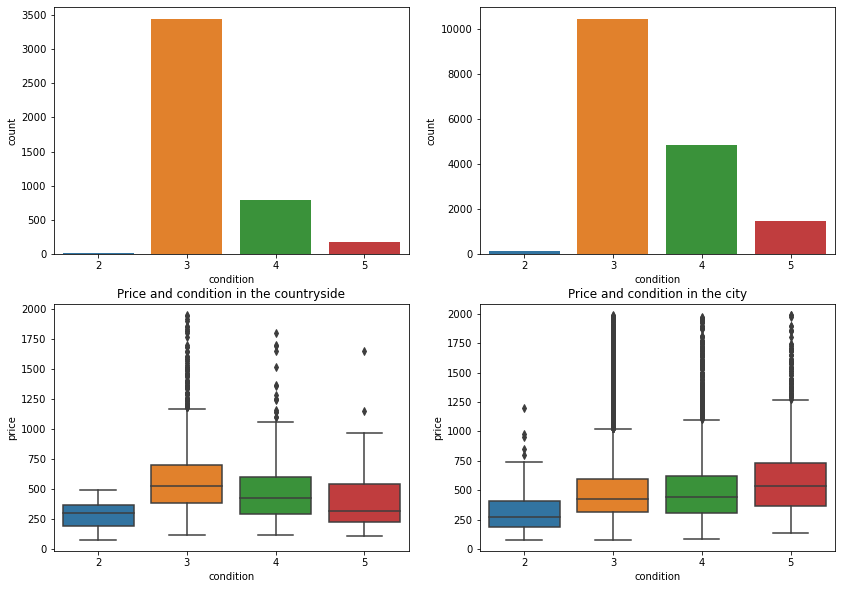

In [69]:
warnings.filterwarnings('ignore')

condition_nature = df_nature["condition"].value_counts()
condition_city = df_city["condition"].value_counts()


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,10))

print("        Count of condition in the countryside \t\t\t Count of condition in the city")
f1 = sns.countplot(x='condition', data=df_nature, ax=ax[0,0]);
#f1.set_xticks(range(1, 11))

f2 = sns.countplot(x='condition', data=df_city, ax=ax[0, 1])
#f2.set_xticks(range(1, 11))


#plt.title("Destribution of number of bedrooms in the countryside")
f3 = sns.boxplot(x='condition', y= 'price',
            data=df_nature, ax=ax[1, 0]).set_title("Price and condition in the countryside")
#f3.set_xticks(range(1, 11))
f4 = sns.boxplot(x='condition', y= 'price',
            data=df_city, ax=ax[1, 1]).set_title("Price and condition in the city")
#f4.set_xticks(range(1, 11))

plt.show()

The ```condition```variable seems to be distributed in a similar way both in the city and the countryside. One difference is though, that ```condition 3 in the countryside```tends to result in the highest price. You can not see this in the city 


**Findings**: Both the condition and the number of bedrooms do not have a big impact on the price. The wishes of the stakeholder will be applicable.

###       Add filters according to talk to stakeholder

In [70]:
df_nature = df_nature.query("bedrooms >= 2 and bedrooms <= 4 and condition >= 3 and yr_renovated == 0.0")

df_city = df_city.query("bedrooms >= 2 and bedrooms <= 4 and condition >= 3")

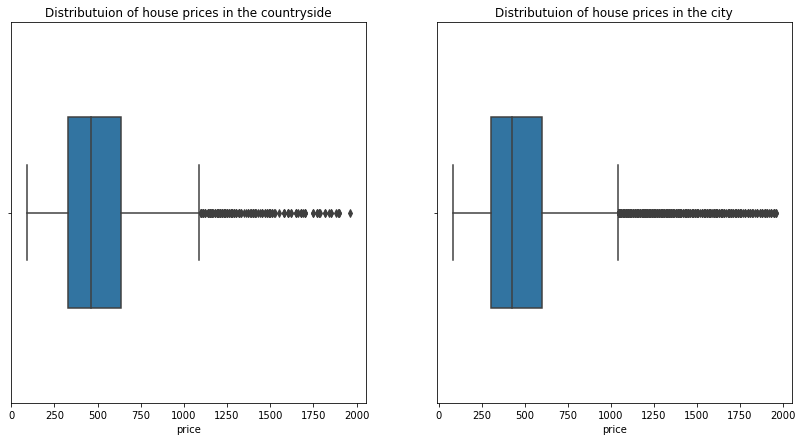

In [52]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14,7))

sns.boxplot( x=df_nature["price"], width=0.5, ax=ax[0]).set_title('Distributuion of house prices in the countryside');
sns.boxplot( x=df_city["price"], width=0.5,  ax=ax[1]).set_title('Distributuion of house prices in the city');
#sns.displot(df_nature, x=df_nature["price"], bins=100, binwidth=20);
#plt.title("Distributuion of house prices in the countryside")
#df_nature.price.describe()



#sns.displot(df_city, x=df_city["price"], bins=100, binwidth=20);
#plt.title("Distributuion of house prices in the city")
#df_city.price.describe()

After applying the filters according to wishes of the stakeholder, there are no major changes in the ```price```variable

### 2.1.3        Map of houses in the countryside

In [24]:
# Visualizing the surrounding 
maxpr=df_nature.loc[df_nature['price'].idxmax()]
#print(maxpr)
def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_nature_copy = df_nature.copy()
df_nature_copy['count'] = 1
basemap = generateBaseMap()
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=df_nature_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

### 2.2.3        Map of houses in the city

In [144]:
# Visualizing the surrounding 
maxpr=df_city.loc[df_city['price'].idxmax()]

def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_city_copy = df_city.copy()
df_city_copy['count'] = 1
basemap = generateBaseMap()
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=df_city_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

##     Splitting into big and small houses

Here, we will further distinguish between ```big``` and ```small``` houses. Big houses lie above the median and small houses below.

In [71]:
df_nature_small = df_nature.query("sqft_living <= sqft_living.median()")
df_nature_big = df_nature.query("sqft_living > sqft_living.median()")
df_city_small = df_city.query("sqft_living <= sqft_living.median()")
df_city_big = df_city.query("sqft_living > sqft_living.median()")

##      Comparison

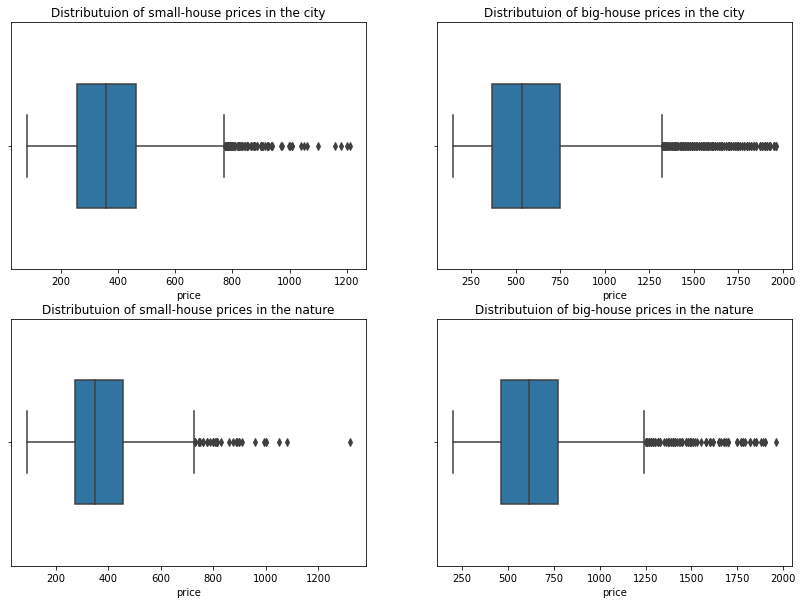

In [60]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,10))

sns.boxplot( x=df_city_small["price"], width=0.5, ax=ax[0, 0]).set_title('Distributuion of small-house prices in the city');
sns.boxplot( x=df_nature_small["price"], width=0.5,  ax=ax[1, 0]).set_title('Distributuion of small-house prices in the nature');
sns.boxplot( x=df_city_big["price"], width=0.5, ax=ax[0, 1]).set_title('Distributuion of big-house prices in the city');
sns.boxplot( x=df_nature_big["price"], width=0.5,  ax=ax[1, 1]).set_title('Distributuion of big-house prices in the nature');

**Findings**: The average prices for ```small houses``` are only slightly higher in the city than in the countryside. This finding confirms my assumption. On the other hand, the average price for ```big houses``` in the city are lower than in the countryside. This is a surprise.

But if you take a deeper look into the fact, you will notice, that big houses in the countryside simply tend to be bigger and therefore more expensive.

in comparison to bigh houses in the countryside(median=616, mean=649),  big houses in the city tend to be cheaper

##  Join the tables

Here we will inspect, what price the customer can expect depending on the size and the location 

In [72]:
df_city_small['key'] = 1
df_nature_small['key'] = 1

result_cs_ns = pd.merge(df_city_small, df_nature_small, on ='key', suffixes=("_city", "_nature")).drop("key", 1) 

In [73]:
result_cs_ns["price"] = result_cs_ns["price_city"] + result_cs_ns["price_nature"]

In [74]:
df_city_big['key'] = 1
df_nature_small['key'] = 1

result_cb_ns = pd.merge(df_city_big, df_nature_small, on ='key', suffixes=("_city", "_nature")).drop("key", 1)
result_cb_ns["price"] = result_cb_ns["price_city"] + result_cb_ns["price_nature"]

In [75]:
df_city_small['key'] = 1
df_nature_big['key'] = 1

result_cs_nb = pd.merge(df_city_small, df_nature_big, on ='key', suffixes=("_city", "_nature")).drop("key", 1)
result_cs_nb["price"] = result_cs_nb["price_city"] + result_cs_nb["price_nature"]

In [76]:
df_city_big['key'] = 1
df_nature_big['key'] = 1

result_cb_nb = pd.merge(df_city_big, df_nature_big, on ='key', suffixes=("_city", "_nature")).drop("key", 1)
result_cb_nb["price"] = result_cb_nb["price_city"] + result_cb_nb["price_nature"]

**Findings**
1. *City small and countryside small* : **median**: 734   and   **mean**: 753 
2. *City big and countryside small*: **median**: 935   and   **mean**: 1013 
3. *City small and countryside big*: **median**: 994   and   **mean**: 1029
4. *City big and countryside small*: **median**: 1210   and   **mean**: 1288 

# 4    Timing for buying a house in the countryside

The customer wants to wait with the purchase of the country house. The question was, if there is a good time to buy a house on the countryside. For answering, the average house prices in the countryside per month were calculated

In [78]:
df_nature_copy = df_nature.copy()

In [79]:
df_nature_copy["month"] = df_nature_copy["date"].apply(lambda x: x[0:2] if len(x) == 10 else x[0:1] )

In [80]:
pd.pivot_table(df_nature_copy, values="price", columns="month")

month,1,10,11,12,2,3,4,5,6,7,8,9
price,524.387796,505.650792,505.504167,517.875611,497.860922,525.117095,563.859933,528.312236,548.748642,536.708694,522.816598,516.203482


In [82]:
monthly_prices = df_nature_copy.groupby("month").price.mean().sort_values()
monthly_prices = monthly_prices.to_frame()
monthly_prices

,price
month,
2,497.860922
11,505.504167
10,505.650792
9,516.203482
12,517.875611
8,522.816598
1,524.387796
3,525.117095
5,528.312236


**Findings**: During wintertime, the average prices for houses in the countryside tend to be lower

# First results and insights

**1: Prices in the city in general tend to be lower**

**2: There is a correlation between size of living space and price. Smaller houses are cheaper**

**3: No major differences between small-house prices in the city and in the countryside**

**4: Big houses in the countryside are more likely to be expensive than inn the city (Against my assumption)**

**5: In the wintertime, prices in the countryside tend to be lower**

# Recommendations

**1: If you want a big house --> buy in the city. But be aware that more space means higher costs**

**2: If you are looking for a small house, it does not really matter if the house is located in the city or in the countryside**

**3: Given the fact, that you are not in a rush to buy a house in the countryside, wait with it for the winter time**

**4: The combination of big house in the city and small house in the natur may be the best option for you**